# Evaluation Analysis for Recommender Output

In this section we will analyze and compare the generated recommendations and predictions from a predefined list of algorithms with the goal of assessing the performance of each algorithm with respect to a metric. In other words, we would rank the algorithms for each metric considered with respect to performance.

## Setup

Below are the list of packages required to successfully run the analysis. They are divided into partitions to signify their specific task.<br>
We need the pathlib package for working with files and folders

In [1]:
from pathlib import Path
import json

Load libraries for analysis and visualization:

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Import the LensKit metrics for analysis:

In [3]:
from lenskit.data import Dataset, ItemListCollection
from lenskit.metrics import RunAnalysis, RMSE, NDCG, RecipRank, RBP

In [4]:
from lkdemo.datasets import split_fraction

## Load Data

The recommendations are in `runs`, and we will need to reassemble the test data from `test`.

In [5]:
dataset = "ml-100k"

In [6]:
# Parameters
dataset = "ml-1m"


In [7]:
output_root = Path("runs")

In [8]:
dirs = [fld for fld in output_root.glob(f'{dataset}-*')]

In [9]:
recs = ItemListCollection(['model', 'user_id'], index=False)
for fld in dirs:
    for file in fld.glob("recs-*"):
        rec = ItemListCollection.load_parquet(file)
        recs.add_from(rec, model=fld.name.split("-")[-1])

In [10]:
rec_algos = sorted(set(a for (a, _u) in recs.keys()))
rec_algos

['ALS', 'Bias', 'IALS', 'IIE', 'III', 'Pop', 'UUE']

In [11]:
preds = ItemListCollection(['model', 'user_id'], index=False)
for fld in dirs:
    for file in fld.glob("pred-*"):
        pred = ItemListCollection.load_parquet(file)
        preds.add_from(pred, model=fld.name.split("-")[-1])

We need to load the test data so that we have the ground truths for computing accuracy.

In [12]:
data = Dataset.load(f"data/{dataset}")
split = split_fraction(data, 0.2)
test = split.test

And identify users in the training set, so we only report metrics over them.

In [13]:
train_users = split.train.user_stats()
train_users = train_users[train_users['rating_count'] > 0]

## Top-N Metrics

`RunListAnalysis` computes metrics for recommendation results and takes care of
matching recommendations and ground truth.

In [14]:
ra = RunAnalysis()

ra.add_metric(NDCG())
ra.add_metric(RecipRank())
ra.add_metric(RBP())

rec_results = ra.compute(recs, test)
rec_results.list_summary('model')

/home/mde48/lenskit/lk-demo-experiment/.venv/lib/python3.13/site-packages/lenskit/metrics/bulk.py:127: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


mean        median       std
model                                            
ALS   NDCG       0.107349  8.762198e-02  0.093322
      RBP        0.138345  6.407255e-02  0.172552
      RecipRank  0.261436  1.250000e-01  0.309230
Bias  NDCG       0.106004  8.564795e-02  0.092345
      RBP        0.137343  7.102358e-02  0.166864
      RecipRank  0.245677  1.250000e-01  0.277671
IALS  NDCG       0.111686  7.055683e-02  0.112362
      RBP        0.112460  1.704118e-02  0.176247
      RecipRank  0.209664  5.882353e-02  0.306494
IIE   NDCG       0.042065  1.194101e-02  0.059622
      RBP        0.029607  2.079036e-07  0.071335
      RecipRank  0.058634  1.176471e-02  0.124962
III   NDCG       0.113907  5.267823e-02  0.139673
      RBP        0.160790  3.669370e-04  0.254071
      RecipRank  0.273850  2.631579e-02  0.392796
Pop   NDCG       0.223519  2.177198e-01  0.130122
      RBP        0.328401  2.596966e-01  0.291568
      RecipRank  0.542564  5.000000e-01  0.418496
UUE   NDCG       0.034722  1.042421e-02  0.047978
      RBP        0.013861  4.815401e-08  0.042194
      RecipRank  0.031511  1.075269e-02  0.060464

We can reshape the list metrics and plot them, after filtering to only users with at least 1 training rating:

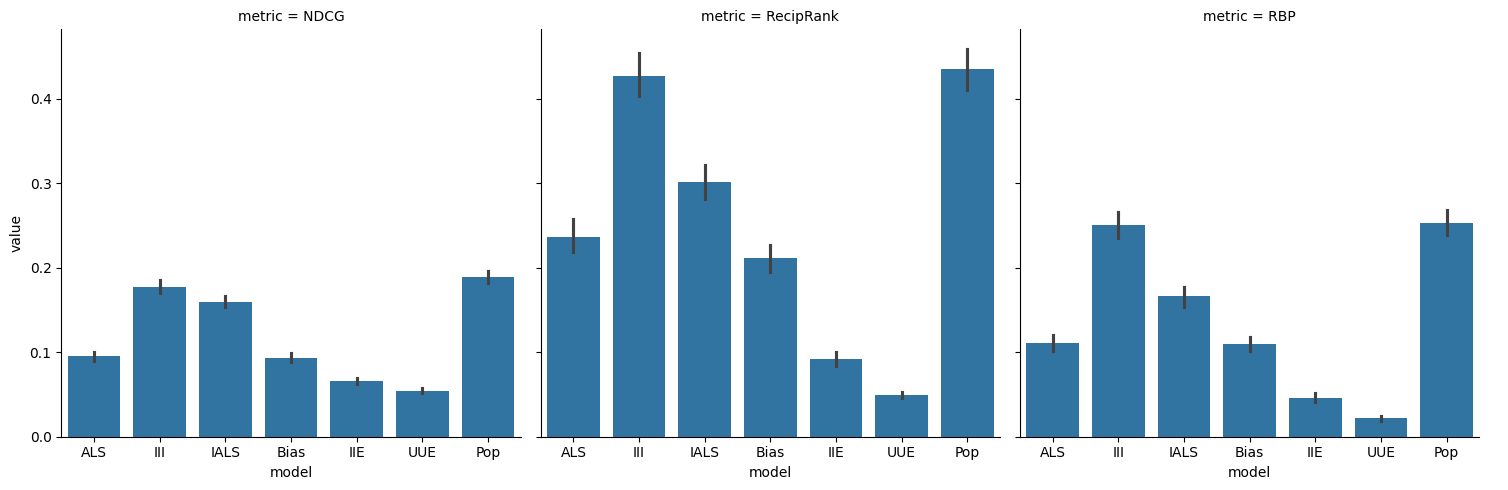

In [15]:
metrics = rec_results.list_metrics()
metrics = metrics.melt(var_name='metric', ignore_index=False).reset_index()
metrics = metrics[metrics['user_id'].isin(train_users.index)]
sns.catplot(metrics, x='model', y='value', col='metric', kind='bar')
plt.show()

Let's look at the influence of training ratings on performance, clamping 15+ into a single category:

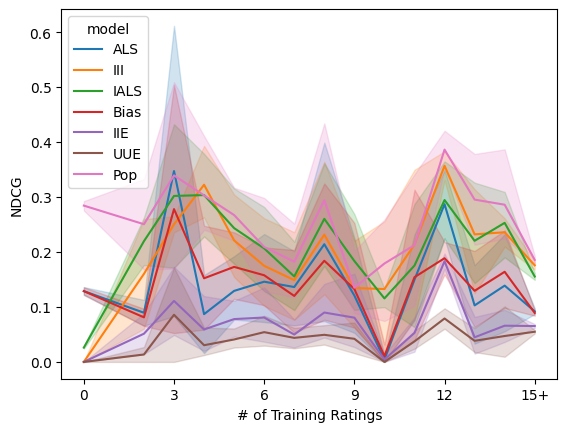

In [16]:
tcounts = split.train.user_stats()['rating_count'].copy()
tcounts[tcounts > 15] = 15
metrics = rec_results.list_metrics().reset_index().join(tcounts, on='user_id')
sns.lineplot(metrics, x='rating_count', y='NDCG', hue='model', errorbar='ci')
plt.xlabel('# of Training Ratings')
rc_ticks = np.arange(0, 16, 3)
plt.xticks(rc_ticks, rc_ticks[:-1].tolist() + ['15+'])
plt.show()

## Prediction RMSE

We will also look at the prediction RMSE.

In [17]:
pa = RunAnalysis()

pa.add_metric(RMSE(missing_scores='ignore', missing_truth='ignore'))

pred_results = pa.compute(preds, test)
pred_results.list_summary('model')

/home/mde48/lenskit/lk-demo-experiment/.venv/lib/python3.13/site-packages/lenskit/metrics/bulk.py:127: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


,,mean,median,std
model,,,,
ALS,RMSE,0.911415,0.883020,0.267941
Bias,RMSE,0.927785,0.901014,0.270145
IIE,RMSE,0.914029,0.883950,0.272659
UUE,RMSE,0.936178,0.908451,0.277874


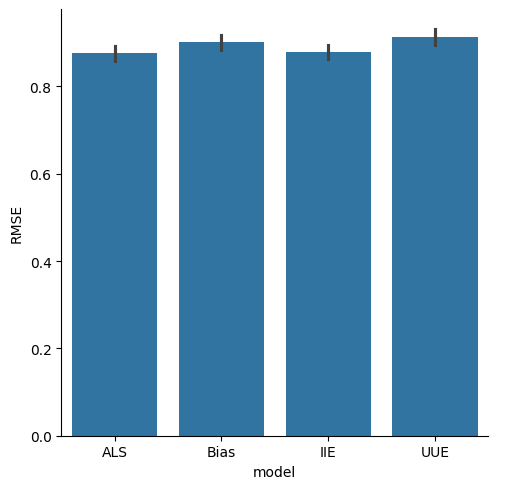

In [18]:
pred_metrics = pred_results.list_metrics().reset_index()
pred_metrics = pred_metrics[pred_metrics['user_id'].isin(train_users.index)]
sns.catplot(pred_metrics, x='model', y='RMSE', kind='bar')
plt.show()

## Save Metrics

We'll now save the metrics to a file.

In [19]:
rlsum = rec_results.list_summary('model')['mean'].unstack()
rlsum

/home/mde48/lenskit/lk-demo-experiment/.venv/lib/python3.13/site-packages/lenskit/metrics/bulk.py:127: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


,NDCG,RBP,RecipRank
model,,,
ALS,0.107349,0.138345,0.261436
Bias,0.106004,0.137343,0.245677
IALS,0.111686,0.112460,0.209664
IIE,0.042065,0.029607,0.058634
III,0.113907,0.160790,0.273850
Pop,0.223519,0.328401,0.542564
UUE,0.034722,0.013861,0.031511


In [20]:
rlsum.to_json(f'eval-metrics.{dataset}.json', orient='index')